In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import seaborn as sns
from datetime import datetime
import RIfunctions as ri

In [2]:
 data = pd.read_csv('RI_Accept.csv', sep = ',', index_col=0)
# data = pd.read_csv('input_file_2.csv', sep = ',', index_col=0)

C:\Users\joshy\AppData\Roaming\Python\Python38\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
data['issue_d'] = pd.to_datetime(data['issue_d'])

In [4]:
print(data.shape)

(15384462, 6)


In [5]:
data = data.loc[data['issue_d'] < '2016-1-1']

In [6]:
print(data.columns)

Index(['loan_amnt', 'emp_length', 'issue_d', 'purpose', 'dti', 'charged_off'], dtype='object')


In [7]:
data['purpose'].value_counts()

debt_consolidation    3044580
credit_card            821506
other                  797106
home_improvement       350297
car                    233647
major_purchase         201942
moving                 183352
medical                175256
small_business         174688
house                   82163
vacation                75382
wedding                 19629
Business                17108
renewable_energy        14825
Name: purpose, dtype: int64

In [8]:
data.isna().sum()

loan_amnt           0
emp_length     139961
issue_d             0
purpose             0
dti                 0
charged_off         0
dtype: int64

<AxesSubplot:>

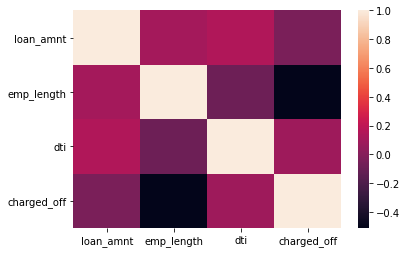

In [9]:
corr = data.corr()

sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6191481 entries, 0 to 15554528
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   loan_amnt    float64       
 1   emp_length   float64       
 2   issue_d      datetime64[ns]
 3   purpose      object        
 4   dti          float64       
 5   charged_off  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 330.7+ MB


In [11]:
train_df = data.loc[data['issue_d'] < data['issue_d'].quantile(0.80)]
test_df = data.loc[data['issue_d'] >= data['issue_d'].quantile(0.80)]

In [12]:
train_df.drop('issue_d', axis=1, inplace=True)
test_df.drop('issue_d', axis=1, inplace=True)

c:\Users\joshy\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [13]:
test_df['charged_off'].value_counts()

1.0    1188081
0.0      52765
Name: charged_off, dtype: int64

In [14]:
train_df['emp_length'].fillna(train_df['emp_length'].mean(), inplace = True)
test_df['emp_length'].fillna(test_df['emp_length'].mean(), inplace=True)
print('null values      ', train_df.isnull().sum())

null values       loan_amnt      0
emp_length     0
purpose        0
dti            0
charged_off    0
dtype: int64


c:\Users\joshy\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [15]:
train_df = ri.balanceData(train_df)
test_df =  ri.balanceData(test_df)

print('train and test shape     ', train_df.shape, test_df.shape)
print('value counts train     ', train_df['charged_off'].value_counts())
print('value counts test     ', test_df['charged_off'].value_counts())

train and test shape      (925988, 5) (105530, 5)
value counts train      0.0    462994
1.0    462994
Name: charged_off, dtype: int64
value counts test      0.0    52765
1.0    52765
Name: charged_off, dtype: int64


In [16]:
# all_cols = list(train_df.columns)
# all_cols.remove('charged_off')
numerical_cols = ['loan_amnt', 'emp_length', 'dti']
# for i in numerical_cols:

#     all_cols.remove(i)

# cat_cols = all_cols
cat_cols = ['purpose']
train_df = train_df[['loan_amnt', 'emp_length', 'dti','purpose','charged_off']]
test_df = test_df[['loan_amnt', 'emp_length', 'dti','purpose','charged_off']]

In [17]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [18]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup()
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup()

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [19]:
# Test the impact on the model when including repeat, prefetch and shuffle buffer

def easy_input_function(df, label_key, shuffle, batch_size):
  label = df[label_key]
  
  ds = tf.data.Dataset.from_tensor_slices((dict(df),label))

  if shuffle:
    ds = ds.shuffle(10000)

  # Split into batches for quicker training and computing resources
  ds = ds.batch(batch_size)

  return ds

In [20]:
train_ds = easy_input_function(train_df, label_key='charged_off', shuffle=False, batch_size=20000)
test_ds = easy_input_function(test_df, label_key='charged_off', shuffle=False, batch_size=200000)

In [21]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in numerical_cols:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [22]:
for header in cat_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               )
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

In [23]:
all_features = tf.keras.layers.concatenate(encoded_features)
# 19 features
layer1 = tf.keras.layers.Dense(5, input_dim=len(all_inputs), activation="tanh")(all_features)
d1 = tf.keras.layers.Dropout(0.2)(layer1)
layer2 = tf.keras.layers.Dense(5, input_dim=5, activation="tanh")(d1)
d2 = tf.keras.layers.Dropout(0.2)(layer2)
output = tf.keras.layers.Dense(1, activation="sigmoid")(d2)

model = tf.keras.Model(all_inputs, output)

In [24]:
model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=[ tf.keras.metrics.AUC(from_logits=False), tf.keras.metrics.Recall()])

In [25]:
history = model.fit(train_ds, epochs=300)

Epoch 1/300


C:\Users\joshy\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py:582: UserWarning: Input dict contained keys ['charged_off'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


47/47 [==============================] - 4s 69ms/step - loss: 0.9034 - auc: 0.2507 - recall: 0.3100 0s - loss: 0.9147 - 
Epoch 2/300
47/47 [==============================] - 3s 73ms/step - loss: 0.8017 - auc: 0.3525 - recall: 0.4047 0s - loss: 0.8080 - auc: 0
Epoch 3/300
47/47 [==============================] - 4s 81ms/step - loss: 0.7280 - auc: 0.4858 - recall: 0.4847
Epoch 4/300
47/47 [==============================] - 4s 77ms/step - loss: 0.6637 - auc: 0.6346 - recall: 0.5873
Epoch 5/300
47/47 [==============================] - 4s 89ms/step - loss: 0.6104 - auc: 0.7344 - recall: 0.6937
Epoch 6/300
47/47 [==============================] - 4s 80ms/step - loss: 0.5689 - auc: 0.7880 - recall: 0.7626
Epoch 7/300
47/47 [==============================] - 4s 80ms/step - loss: 0.5378 - auc: 0.8174 - recall: 0.8002
Epoch 8/300
47/47 [==============================] - 4s 80ms/step - loss: 0.5152 - auc: 0.8341 - recall: 0.8203
Epoch 9/300
47/47 [==============================] - 4s 81ms/step - 

KeyboardInterrupt: 

In [26]:
loss, auc, recall = model.evaluate(test_ds)

1/1 [==============================] - 1s 715ms/step - loss: 0.4203 - auc: 0.8979 - recall: 0.8507
